## ACTLE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True


In [2]:
# CSV to S2P
import csv
import math
from pathlib import Path

def csv_to_s2p_db(csv_path: str,
                  s2p_path: str | None = None,
                  delimiter: str = ";",
                  quotechar: str = '"',
                  z0: float = 50.0,
                  freq_col: str = "frequency",
                  re_db_col: str = "r dBS21",
                  im_db_col: str = "i dBS21",
                  assume_imag_db_is_phase_deg: bool = False,
                  default_phase_deg: float = 0.0):
    """
    Convierte un .csv (con columnas tipo: frequency; r dBS21; i dBS21) a un .s2p Touchstone:

      # Hz S RI R 50
      f  S11re S11im  S21re S21im  S12re S12im  S22re S22im

    Interpretación del CSV:
      - freq_col: frecuencia en Hz (numérico)
      - re_db_col: magnitud en dB de S21 (por ejemplo -3.2 dB)
      - im_db_col: por defecto se interpreta como 0 y se usa phase=default_phase_deg.
                  Si assume_imag_db_is_phase_deg=True, se interpreta como fase en grados.

    Como el CSV solo trae S21, el resto se completa con ceros:
      S11 = 0, S12 = 0, S22 = 0

    Nota: escribir S11/S12/S22 en cero es válido para “usar S21 como canal”,
    pero NO representa un 2-puertos físicamente consistente.
    """
    csv_path = str(csv_path)
    if s2p_path is None:
        s2p_path = str(Path(csv_path).with_suffix(".s2p"))

    rows_out = []

    with open(csv_path, "r", newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f, delimiter=delimiter, quotechar=quotechar)
        # normalizar nombres por si vienen con espacios raros
        fieldnames = {name.strip(): name for name in reader.fieldnames or []}

        def get_key(wanted: str):
            if wanted in fieldnames:
                return fieldnames[wanted]
            # fallback: match case-insensitive
            for k in fieldnames:
                if k.lower() == wanted.lower():
                    return fieldnames[k]
            raise KeyError(f"No encuentro la columna '{wanted}' en el CSV. Columnas: {list(fieldnames)}")

        k_f  = get_key(freq_col)
        k_re = get_key(re_db_col)
        k_im = get_key(im_db_col)

        for r in reader:
            f_hz = float(r[k_f])

            mag_db = float(r[k_re])
            mag_lin = 10 ** (mag_db / 20.0)

            if assume_imag_db_is_phase_deg:
                ph_deg = float(r[k_im])
            else:
                # si tu columna i dBS21 es siempre 0, esto es lo correcto
                ph_deg = default_phase_deg

            ph_rad = math.radians(ph_deg)
            s21_re = mag_lin * math.cos(ph_rad)
            s21_im = mag_lin * math.sin(ph_rad)

            # Touchstone 2-port: f  S11  S21  S12  S22  (cada uno re/im)
            rows_out.append((f_hz, 0.0, 0.0, s21_re, s21_im, 0.0, 0.0, 0.0, 0.0))

    with open(s2p_path, "w", encoding="utf-8") as f:
        f.write(f"# Hz S RI R {z0:g}\n")
        for row in rows_out:
            f.write("{:.6e} {:.6e} {:.6e} {:.6e} {:.6e} {:.6e} {:.6e} {:.6e} {:.6e}\n".format(*row))

    return s2p_path




In [3]:
def pam4_symbols(n_symbols: int, seed: int = 1):
    rng = np.random.default_rng(seed)
    levels = np.array([-0.25, -0.125, 0.125, 0.25], dtype=float)
    return rng.choice(levels, size=n_symbols)

def pam4_waveform(symbols: np.ndarray, sps: int):
    return np.repeat(symbols, sps)


In [4]:
def ctle_2p1z_tf(Gain: float, fz_hz: float, fp1_hz: float, fp2_hz: float, invert: bool = False):
    """
    H(s) = Gain * (s + wz) / ((s + wp1)(s + wp2))   (analógica)
    """
    wz  = 2*np.pi*fz_hz
    wp1 = 2*np.pi*fp1_hz
    wp2 = 2*np.pi*fp2_hz
    g = -Gain if invert else Gain

    num = [g, g*wz]
    den = [1.0, (wp1 + wp2), (wp1 * wp2)]
    return signal.TransferFunction(num, den)

def tf_resp_at_f(tf: signal.TransferFunction, f_hz: np.ndarray):
    w = 2*np.pi*f_hz
    _, H = signal.freqs(tf.num, tf.den, worN=w)
    return H

def mag_db(H: np.ndarray, floor_db: float = -200.0):
    return 20*np.log10(np.maximum(np.abs(H), 10**(floor_db/20)))

def phase_deg(H: np.ndarray):
    return np.unwrap(np.angle(H)) * 180/np.pi

def read_s2p_ri(path: str):
    """
    Touchstone .s2p: '# Hz S RI R 50'
    Datos: f  S11re S11im  S21re S21im  S12re S12im  S22re S22im
    """
    header = None
    rows = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("!"):
                continue
            if line.startswith("#"):
                header = line
                continue
            rows.append(line)

    if header is None:
        raise ValueError("No se encontró header '#' en el .s2p.")

    tokens = header.split()
    unit = tokens[1].upper()
    fmt  = tokens[3].upper()
    if fmt != "RI":
        raise ValueError(f"Formato '{fmt}' no implementado (solo RI).")

    data = np.loadtxt(rows)
    if data.ndim == 1:
        data = data[None, :]

    if data.shape[1] < 9:
        raise ValueError(f"Se esperaban 9 columnas, llegaron {data.shape[1]}.")

    unit_scale = {"HZ": 1.0, "KHZ": 1e3, "MHZ": 1e6, "GHZ": 1e9}
    if unit not in unit_scale:
        raise ValueError(f"Unidad '{unit}' no reconocida.")

    freq_hz = data[:, 0] * unit_scale[unit]

    S11 = data[:, 1] + 1j*data[:, 2]
    S21 = data[:, 3] + 1j*data[:, 4]
    S12 = data[:, 5] + 1j*data[:, 6]
    S22 = data[:, 7] + 1j*data[:, 8]

    return freq_hz, {"S11": S11, "S21": S21, "S12": S12, "S22": S22}

def track_and_hold(y: np.ndarray, sps: int, sample_offset: float = 0.5):
    n_syms = len(y) // sps
    k0 = int(np.floor(sample_offset * sps))
    idx = k0 + np.arange(n_syms) * sps
    y_samp = y[idx]
    y_hold = np.repeat(y_samp, sps)
    return y_samp, y_hold, idx

def plot_eye(y: np.ndarray, sps: int, ui_span: int = 2, n_traces: int = 200, title="Eye"):
    seg_len = ui_span * sps
    n_syms = len(y) // sps
    max_traces = min(n_traces, n_syms - ui_span - 1)

    starts = np.arange(0, max_traces) * sps
    t_ui = np.linspace(0, ui_span, seg_len, endpoint=False)

    plt.figure(figsize=(8, 4))
    for s in starts:
        seg = y[s:s+seg_len]
        if len(seg) == seg_len:
            plt.plot(t_ui, seg, linewidth=0.8, alpha=0.35)
    plt.grid(True, alpha=0.3)
    plt.xlabel("Tiempo [UI]")
    plt.ylabel("Amplitud [V]")
    plt.title(title)
    plt.show()


In [5]:
import numpy as np
from scipy import signal

def _interp_mag_phase(freq_hz, H, f_new_hz, left="hold", right="hold"):
    """Interpola magnitud y fase (unwrap) para evitar problemas de wrap."""
    freq_hz = np.asarray(freq_hz)
    H = np.asarray(H)

    mag = np.abs(H)
    ph  = np.unwrap(np.angle(H))

    if left == "zero":
        mag_l, ph_l = 0.0, ph[0]
    else:  # hold
        mag_l, ph_l = mag[0], ph[0]

    if right == "zero":
        mag_r, ph_r = 0.0, ph[-1]
    else:  # hold
        mag_r, ph_r = mag[-1], ph[-1]

    mag_i = np.interp(f_new_hz, freq_hz, mag, left=mag_l, right=mag_r)
    ph_i  = np.interp(f_new_hz, freq_hz, ph,  left=ph_l,  right=ph_r)

    return mag_i * np.exp(1j * ph_i)

def estimate_delay_samples(freq_hz, H, Fs, passband_db=20):
    """
    Estima un retardo (en muestras) a partir de la group delay:
      tau(f) = - d(phi)/d(omega)
    Usa la mediana en una zona de "pasabanda" (|H| cerca del máximo).
    """
    H = np.asarray(H)
    mag_db = 20*np.log10(np.maximum(np.abs(H), 1e-30))
    thr = mag_db.max() - passband_db
    mask = mag_db >= thr

    f = np.asarray(freq_hz)[mask]
    if f.size < 8:
        return 0

    phi = np.unwrap(np.angle(H[mask]))
    w = 2*np.pi*f

    tau = -np.gradient(phi, w)
    tau = tau[np.isfinite(tau)]
    if tau.size == 0:
        return 0

    tau_med = np.median(tau)
    if tau_med < 0:
        tau_med = 0.0

    return int(np.ceil(tau_med * Fs))

def build_channel_fir_from_s21(freq_meas_hz: np.ndarray,
                               S21_meas: np.ndarray,
                               Fs: float,
                               Nfft: int = 65536,
                               ntaps: int = 2048,
                               left_fill: str = "hold",
                               right_fill: str = "hold",
                               delay_samples = 0,          # 0, int, o "estimate"
                               window: str | None = None   # None, "hann", "kaiser"
                              ):
    """
    Construye un FIR h[n] cuya respuesta compleja aproxima S21(f) (en la banda 0..Fs/2).

    - Interpola S21 a la grilla de rFFT (magnitud+fase unwrap).
    - (Opcional) añade retardo causal: multiplica por exp(-j2π f * delay/Fs).
    - irfft -> h[n] real (si DC/Nyquist son reales).
    - Trunca a ntaps (y ventana opcional).

    Devuelve:
      h (ntaps), f_pos (Hz), Hpos_interp (compleja), Hfir (rFFT de h con Nfft)
    """
    freq_meas_hz = np.asarray(freq_meas_hz)
    S21_meas = np.asarray(S21_meas)

    if np.any(np.diff(freq_meas_hz) < 0):
        # asegurar orden creciente
        idx = np.argsort(freq_meas_hz)
        freq_meas_hz = freq_meas_hz[idx]
        S21_meas = S21_meas[idx]

    # Grilla de frecuencia para rFFT
    f_pos = np.fft.rfftfreq(Nfft, d=1/Fs)   # 0..Fs/2, largo Nfft//2+1

    # Interpolación robusta (mag+fase)
    Hpos = _interp_mag_phase(freq_meas_hz, S21_meas, f_pos, left=left_fill, right=right_fill)

    # Forzar DC y Nyquist reales (condición de señal real exacta)
    Hpos[0] = np.real(Hpos[0])
    if Nfft % 2 == 0:  # Nyquist existe
        Hpos[-1] = np.real(Hpos[-1])

    # Retardo (para hacerlo causal sin "roll" arbitrario)
    if isinstance(delay_samples, str) and delay_samples.lower() == "estimate":
        d = estimate_delay_samples(freq_meas_hz, S21_meas, Fs)
    else:
        d = int(delay_samples)

    if d != 0:
        Hpos = Hpos * np.exp(-1j * 2*np.pi * f_pos * (d / Fs))
        Hpos[0] = np.real(Hpos[0])
        if Nfft % 2 == 0:
            Hpos[-1] = np.real(Hpos[-1])

    # Impulso real por construcción (si Hpos cumple simetría Hermítica implícita)
    h = np.fft.irfft(Hpos, n=Nfft)

    # Truncar
    if ntaps > Nfft:
        raise ValueError("ntaps no puede ser mayor que Nfft.")

    h_trunc = h[:ntaps].copy()

    # Ventana opcional (esto mejora ringing pero cambia la TF)
    if window is not None:
        if window.lower() == "hann":
            w = signal.windows.hann(ntaps, sym=False)
            h_trunc *= w
        elif window.lower().startswith("kaiser"):
            # ejemplo: window="kaiser:8"
            parts = window.split(":")
            beta = float(parts[1]) if len(parts) > 1 else 8.0
            w = signal.windows.kaiser(ntaps, beta, sym=False)
            h_trunc *= w
        else:
            raise ValueError("window debe ser None, 'hann' o 'kaiser:beta'.")

    # Respuesta del FIR truncado (para comparar con Hpos)
    Hfir = np.fft.rfft(np.pad(h_trunc, (0, Nfft-ntaps)), n=Nfft)

    return h_trunc, f_pos, Hpos, Hfir


In [ ]:
def plot_reconstruction(f_pos, H_target, H_fir, title="Reconstrucción canal"):
    f_ghz = f_pos / 1e9

    plt.figure(figsize=(10,4))
    plt.semilogx(f_ghz, 20*np.log10(np.maximum(np.abs(H_target), 1e-30)), label="Target (interp S21)")
    plt.semilogx(f_ghz, 20*np.log10(np.maximum(np.abs(H_fir),    1e-30)), "--", label="FIR (rfft)")
    plt.xlabel("Frecuencia [GHz]")
    plt.ylabel("Magnitud [dB]")
    plt.title(title + " — Magnitud")
    plt.grid(True, which="both", alpha=0.3)
    #plt.xlim([1e9,56e9])
    plt.legend()
    plt.show()

    # Error en dB
    err_db = 20*np.log10(np.maximum(np.abs(H_fir), 1e-30)) - 20*np.log10(np.maximum(np.abs(H_target), 1e-30))
    plt.figure(figsize=(10,3))
    plt.semilogx(f_ghz, err_db)
    plt.xlabel("Frecuencia [GHz]")
    plt.ylabel("Error [dB]")
    plt.title(title + " — Error de magnitud (FIR - target)")
    plt.grid(True, which="both", alpha=0.3)
    plt.show()

    # Fase (solo si te interesa)
    ph_t = np.unwrap(np.angle(H_target))*180/np.pi
    ph_f = np.unwrap(np.angle(H_fir))*180/np.pi
    plt.figure(figsize=(10,4))
    plt.semilogx(f_ghz, ph_t, label="Target")
    plt.semilogx(f_ghz, ph_f, "--", label="FIR")
    plt.xlabel("Frecuencia [GHz]")
    plt.ylabel("Fase [deg]")
    plt.title(title + " — Fase (unwrap)")
    plt.grid(True, which="both", alpha=0.3)
    plt.legend()
    plt.show()


Generado: att20dB_14G.s2p


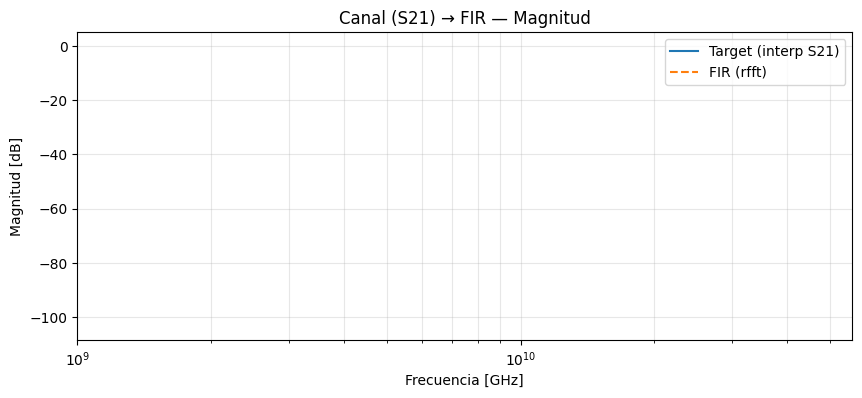

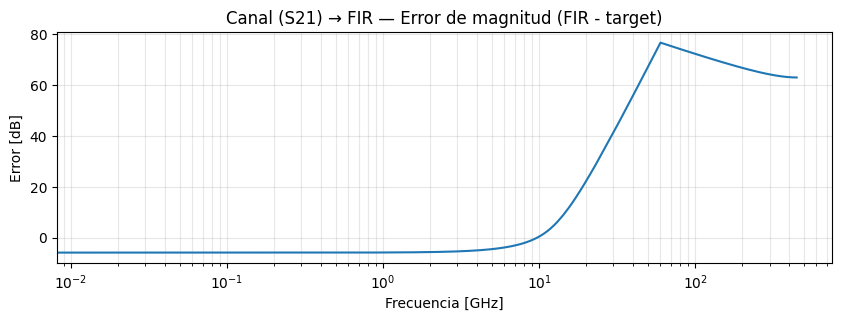

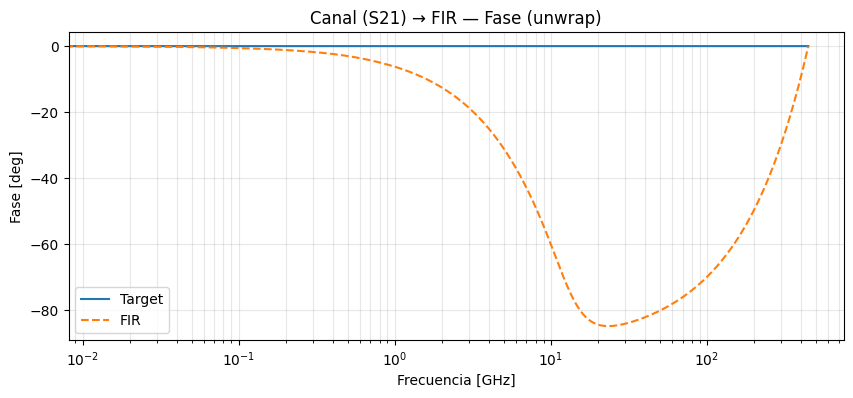

In [12]:
# fs y muestreo del sistema
Rb  = 56e9
sps = 16
Fs  = Rb * sps

# En tu notebook:

out = csv_to_s2p_db("att20dB_14G.csv", assume_imag_db_is_phase_deg=True)
print("Generado:", out)

# Cargar S2P (usando tu lector read_s2p_ri)
freq_hz, S = read_s2p_ri("att20dB_14G.s2p")
S21 = S["S21"]

# Construir FIR (1) sin ventana (mejor “matching”), (2) con delay estimado si hace falta
h_ch, f_pos, Hpos, Hfir = build_channel_fir_from_s21(
    freq_meas_hz=freq_hz,
    S21_meas=S21,
    Fs=Fs,
    Nfft=65536,
    ntaps=2048,
    left_fill="hold",
    right_fill="hold",
    delay_samples="0",   # probá 0 si tu S21 tiene fase ~0
    window=None                 # poné "hann" si preferís menos ringing, aceptando error extra
)

plot_reconstruction(f_pos, Hpos, Hfir, title="Canal (S21) → FIR")



In [8]:
# ---- CTLEs analógicos ----
CTLE1 = ctle_2p1z_tf(Gain=2.0, fz_hz=10e9, fp1_hz=22e9, fp2_hz=45e9, invert=False)
CTLE2 = ctle_2p1z_tf(Gain=2.0, fz_hz=11e9, fp1_hz=24e9, fp2_hz=50e9, invert=False)

Av = 1.0  # VGA

# ---- Discretización (bilinear) para simular en tiempo discreto ----
b1z, a1z, _ = signal.cont2discrete((CTLE1.num, CTLE1.den), dt, method="bilinear")
b2z, a2z, _ = signal.cont2discrete((CTLE2.num, CTLE2.den), dt, method="bilinear")

b1z = np.squeeze(b1z); a1z = np.squeeze(a1z)
b2z = np.squeeze(b2z); a2z = np.squeeze(a2z)

# ---- Respuesta en frecuencia en la misma grilla f_pos (0..Fs/2) ----
# Canal: medido (interpolado a f_pos) y el aproximado FIR (Hfir)
Hch_meas = Hpos_interp
Hch_fir  = Hfir

# CTLEs discretos
w = 2*np.pi * (f_pos / Fs)  # rad/muestra
_, H1z = signal.freqz(b1z, a1z, worN=w)
_, H2z = signal.freqz(b2z, a2z, worN=w)

Htot_meas = Hch_meas * H1z * H2z * Av
Htot_fir  = Hch_fir  * H1z * H2z * Av

print("CTLE1(bz,az) lens:", len(b1z), len(a1z))
print("CTLE2(bz,az) lens:", len(b2z), len(a2z))


NameError: name 'dt' is not defined

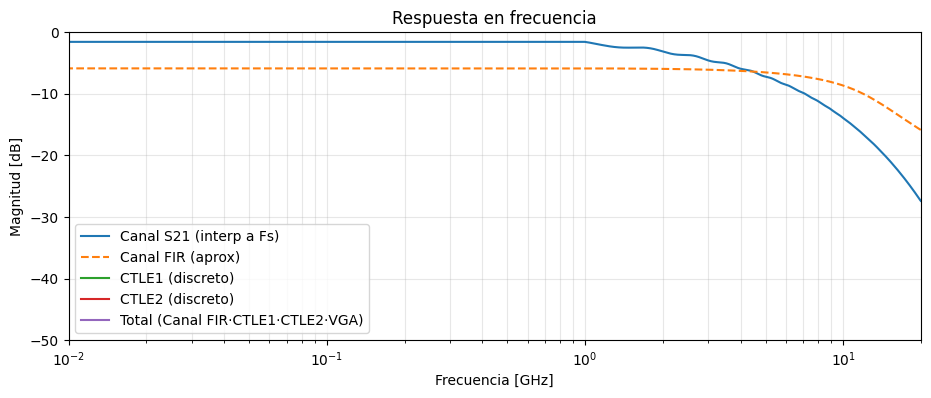

In [ ]:
f_ghz = f_pos / 1e9

plt.figure(figsize=(11, 4))
plt.semilogx(f_ghz, mag_db(Hch_meas), label="Canal S21 (interp a Fs)")
plt.semilogx(f_ghz, mag_db(Hch_fir),  "--", label="Canal FIR (aprox)")
plt.semilogx(f_ghz, mag_db(H1z), label="CTLE1 (discreto)")
plt.semilogx(f_ghz, mag_db(H2z), label="CTLE2 (discreto)")
plt.semilogx(f_ghz, mag_db(Htot_fir), label="Total (Canal FIR·CTLE1·CTLE2·VGA)")
plt.xlabel("Frecuencia [GHz]")
plt.ylabel("Magnitud [dB]")
plt.title("Respuesta en frecuencia")
plt.xlim([1e-2,2e1])
plt.ylim(-50,0)
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.show()


In [ ]:
# Tiempo y señal PAM4
UI = 1.0 / Rb
t = np.arange(n_symbols * sps) * dt

sym = pam4_symbols(n_symbols, seed=seed)
x = pam4_waveform(sym, sps)

# Canal FIR
y_ch = signal.lfilter(h_ch, [1.0], x)

# CTLEs discretos
y1 = signal.lfilter(b1z, a1z, y_ch)
y2 = signal.lfilter(b2z, a2z, y1)

# VGA
y = Av * y2

print("Señales listas:", "x", x.shape, "y", y.shape)


Señales listas: x (32768,) y (32768,)


In [ ]:
target_vpp = 0.5  # 500 mVpp
sample_offset = 0.5

y_samp, y_hold, idx = track_and_hold(y, sps=sps, sample_offset=sample_offset)

vpp_before = np.ptp(y_samp)
if vpp_before <= 0:
    raise RuntimeError("vpp_before = 0 (revisar cadena).")

scale = target_vpp / vpp_before

y      = y * scale
y_samp = y_samp * scale
y_hold = y_hold * scale

print("---- Resumen ----")
print(f"UI = {UI*1e12:.3f} ps | Fs = {Fs/1e9:.3f} GHz | dt = {dt*1e12:.3f} ps")
print(f"Vpp muestreado antes: {vpp_before*1e3:.3f} mVpp")
print(f"Scale aplicado: {scale:.4g}")
print(f"Vpp muestreado después: {np.ptp(y_samp)*1e3:.3f} mVpp")


---- Resumen ----
UI = 17.857 ps | Fs = 896.000 GHz | dt = 1.116 ps
Vpp muestreado antes: 0.000 mVpp
Scale aplicado: 1.722e+23
Vpp muestreado después: 500.000 mVpp


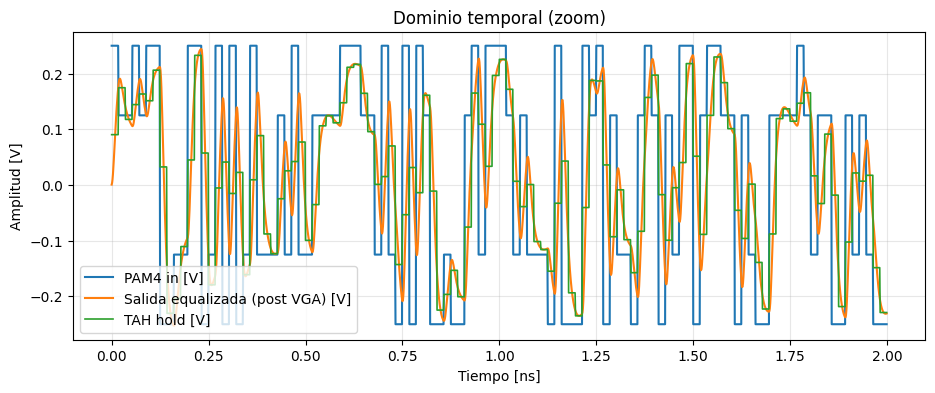

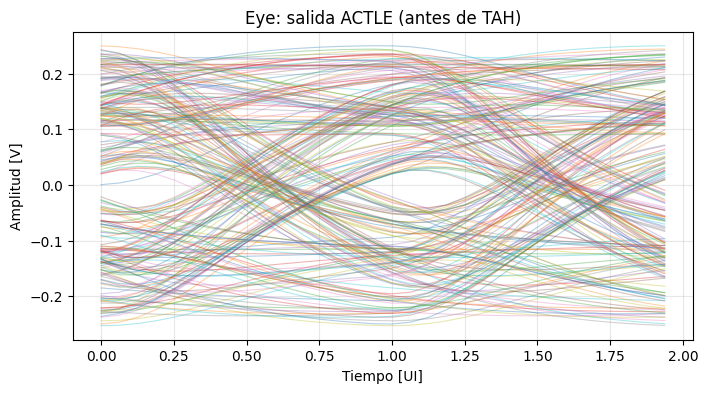

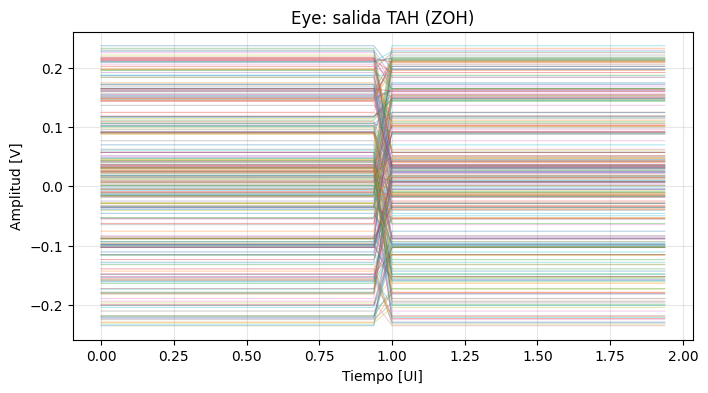

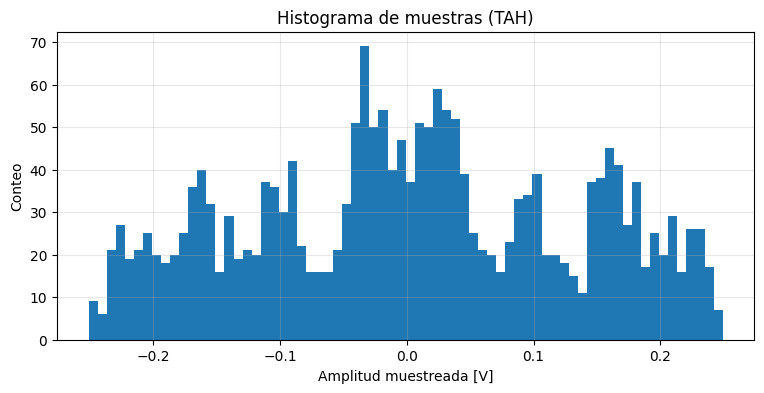

In [ ]:
# Zoom temporal (elegí ventana)
ns_view = 2.0e-9
n_view = int(ns_view / dt)

plt.figure(figsize=(11, 4))
plt.plot(t[:n_view]*1e9, x[:n_view], label="PAM4 in [V]")
plt.plot(t[:n_view]*1e9, y[:n_view], label="Salida equalizada (post VGA) [V]")
plt.plot(t[:n_view]*1e9, y_hold[:n_view], label="TAH hold [V]", linewidth=1.2)
plt.xlabel("Tiempo [ns]")
plt.ylabel("Amplitud [V]")
plt.title("Dominio temporal (zoom)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Eye diagrams
plot_eye(y, sps=sps, ui_span=2, n_traces=250, title="Eye: salida ACTLE (antes de TAH)")
plot_eye(y_hold, sps=sps, ui_span=2, n_traces=250, title="Eye: salida TAH (ZOH)")

# Histograma de muestras
plt.figure(figsize=(9, 4))
plt.hist(y_samp, bins=70)
plt.xlabel("Amplitud muestreada [V]")
plt.ylabel("Conteo")
plt.title("Histograma de muestras (TAH)")
plt.grid(True, alpha=0.3)
plt.show()
